# 基本的な探索的データ分析・特徴量作成ならびに学習器作成 01

- 日本語で書きますが、何かおかしな単語・やってること等あればコメント欄にどうぞ。
- 改変等は自由にどうぞ。


- 2019/09/29 投稿

## 1. lmport library

In [1]:
import numpy as np
print('numpy version:', np.__version__)
import pandas as pd
print('pandas version:', pd.__version__)
import seaborn as sns
print('seaborn version:', sns.__version__)
import matplotlib
import matplotlib.pyplot as plt
print('matploblib version:', matplotlib.__version__)

import lightgbm as lgb
print('lightgbm version:', lgb.__version__)

from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import sklearn
print('sklearn version:', sklearn.__version__)

import warnings
warnings.filterwarnings('ignore')

import os
#print(os.listdir())

numpy version: 1.15.4
pandas version: 0.24.1
seaborn version: 0.9.0
matploblib version: 3.0.2
lightgbm version: 2.2.1
sklearn version: 0.20.2


## 2. Read data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submit = pd.read_csv('sample_submit.csv', names=('id', 'target'))

train = train.rename(columns={'賃料':'target', '契約期間':'Contract', '間取り':'Room', 
                              '築年数':'Passed', '駐車場':'Parking', '室内設備':'Facility', 
                              '放送・通信':'Internet', '周辺環境':'Building', '建物構造':'Material', 
                              '面積':'Area', 'キッチン':'Kitchen', '所在地':'Place',
                              'バス・トイレ':'Bath', '所在階':'Floor', 'アクセス':'Access', 
                              '方角':'Angle'})
test = test.rename(columns={'契約期間':'Contract', '間取り':'Room', '築年数':'Passed', 
                            '駐車場':'Parking', '室内設備':'Facility', '放送・通信':'Internet', 
                            '周辺環境':'Building', '建物構造':'Material', '面積':'Area', 
                            'キッチン':'Kitchen', '所在地':'Place', 'バス・トイレ':'Bath', 
                            '所在階':'Floor', 'アクセス':'Access', '方角':'Angle'})

- グラフの描画等で特徴量に不具合が出る場合がある為、適当な半角文字に直しています。

## 3. Basic EDA

- ここでは、基本的なEDAを行います。
- おそらくですが、ほとんどやってることは大差ない（むしろ少ない）かと思うので、適宜、追加するのが良いかと思います。

In [3]:
train.head(10)

,id,target,Place,Access,Room,Passed,Angle,Area,Floor,Bath,Kitchen,Internet,Facility,Parking,Building,Material,Contract
0,1,75000,東京都北区滝野川３丁目,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,9年9ヶ月,南東,20.01m2,1階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,RC（鉄筋コンクリート）,2年間
1,2,76000,東京都中央区月島３丁目,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,1R,44年10ヶ月,NaN,16.5m2,5階／10階建,専用トイレ／\tシャワー／\t温水洗浄便座,ガスコンロ／\tシステムキッチン\t／\t給湯,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 1283m,鉄骨造,2年間
2,3,110000,東京都渋谷区笹塚２丁目,京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...,1K,8年6ヶ月,南,22.05m2,12階／15階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ,エアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフローリング...,"駐輪場\t空有\tバイク置き場\t空有\t駐車場\t近隣\t30,000円(税込)\t距離100m",【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m,RC（鉄筋コンクリート）,2年間
3,4,150000,東京都杉並区高円寺南２丁目23-2,総武線・中央線（各停）\t高円寺駅\t徒歩9分\t\t丸ノ内線(池袋－荻窪)\t新高円寺駅\...,2LDK,29年4ヶ月,南,60.48m2,3階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座／\t洗面台独立,ガスコンロ／\t給湯,インターネット対応／\t光ファイバー,エアコン付\tシューズボックス／\tバルコニー／\t2面採光／\t室内洗濯機置場／\tエレベ...,駐車場\t無\t駐輪場\t無\tバイク置き場\t無,【スーパー】 225m\t【スーパー】 448m\t【スーパー】 619m\t【スーパー】 ...,RC（鉄筋コンクリート）,2年間\t※この物件は\t定期借家\tです。
4,5,74000,東京都葛飾区金町３丁目7-2,京成金町線\t京成金町駅\t徒歩5分\t\t常磐線\t金町(東京都)駅\t徒歩7分\t\t京...,2DK,31年7ヶ月,南,39.66m2,1階／2階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能,給湯／\t独立キッチン,NaN,バルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水,"駐車場\t近隣\t17,000円(税込)\t距離300m\t駐輪場\t無\tバイク置き場\t無",【スーパー】 193m\t【スーパー】 298m\t【スーパー】 660m\t【スーパー】 ...,木造,2年間
5,6,160000,東京都荒川区南千住５丁目,常磐線快速\t南千住駅\t徒歩2分\t\t都電荒川線\t三ノ輪橋駅\t徒歩10分\t\t日比...,2LDK,7年6ヶ月,東,50.8m2,6階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\t給湯／\t独立キッチン,インターネット対応／\t光ファイバー,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...,"駐輪場\t空有\t駐車場\t近隣\t27,000円(税込)\t距離150m\tバイク置き場\t無",【スーパー】 251m\t【コンビニ】 376m,RC（鉄筋コンクリート）,2年間
6,7,78500,東京都練馬区東大泉３丁目,西武池袋線\t大泉学園駅\t徒歩4分\t\t西武池袋線\t保谷駅\t徒歩25分\t\t東武東...,1K,10年5ヶ月,南,23.82m2,6階／8階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCATV／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...,"駐輪場\t空有\t駐車場\t近隣\t16,000円(税込)\t距離200m\tバイク置き場\t無",【スーパー】 812m\t【コンビニ】 149m\t【コンビニ】 942m\t【スーパー】 ...,RC（鉄筋コンクリート）,2年間
7,8,115000,東京都目黒区鷹番１丁目,東急東横線\t学芸大学駅\t徒歩7分\t\t東急東横線\t都立大学駅\t徒歩16分\t\t東...,1K,14年4ヶ月,NaN,32.32m2,1階／6階建,専用バス／\t専用トイレ／\tバス・トイレ別／\t追焚機能／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン,光ファイバー／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気システム\...,NaN,【スーパー】 334m\t【スーパー】 562m\t【スーパー】 694m\t【コンビニ】 ...,RC（鉄筋コンクリート）,2年間
8,9,184327,東京都文京区向丘１丁目,南北線\t東大前駅\t徒歩3分\t\t都営三田線\t白山(東京都)駅\t徒歩10分\t\t千...,2DK,44年8ヶ月,北西,65.59m2,4階／9階建,専用バス／\t専用トイレ／\tバス・トイレ別／\t追焚機能／\t洗面台独立,ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\t給湯,NaN,エアコン付\tバルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t都市ガス,駐車場\t無,NaN,SRC（鉄骨鉄筋コンクリート）,2年間
9,10,76000,東京都板橋区板橋４丁目,埼京線\t板橋駅\t徒歩8分\t\t都営三田線\t新板橋駅\t徒歩4分\t\t東武東上線\t...,1DK,38年9ヶ月,南東,30.3m2,2階／3階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t洗面台独立,ガスコンロ／\tコンロ2口／\t給湯,光ファイバー／\tCATV,エアコン付\tバルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t都市ガス,駐車場\t無,NaN,鉄骨造,2年間


In [4]:
test.head(10)

,id,Place,Access,Room,Passed,Angle,Area,Floor,Bath,Kitchen,Internet,Facility,Parking,Building,Material,Contract
0,31471,東京都世田谷区深沢５丁目1-27,東急大井町線\t等々力駅\t徒歩15分\t\t東急田園都市線\t桜新町駅\t徒歩24分\t\...,2LDK,49年0ヶ月,南,50.22m2,8階／8階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t温水洗浄便座／...,ガスコンロ／\tコンロ3口／\tシステムキッチン\t／\t給湯／\tL字キッチン,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\tエレベーター\t公営水...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【コンビニ】 74m\t【スーパー】 215m\t【病院】 313m\t【小学校】 219m...,鉄骨造,NaN
1,31472,東京都目黒区八雲１丁目11-8,東急東横線\t都立大学駅\t徒歩6分\t\t東急東横線\t自由が丘駅\t徒歩17分\t\t東...,1R,0年2ヶ月,南東,20.88m2,3階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCSアンテナ／\tBSアンテナ／\tインターネット使用料無料,エアコン付\tシューズボックス／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水／...,"駐車場\t近隣\t34,000円(税込)\t距離200m\t駐輪場\t無\tバイク置き場\t無",【スーパー】 128m\t【スーパー】 313m\t【コンビニ】 374m\t【コンビニ】 ...,RC（鉄筋コンクリート）,2年間
2,31473,東京都豊島区池袋本町２丁目22-2,東武東上線\t北池袋駅\t徒歩10分\t\t埼京線\t板橋駅\t徒歩16分\t\t山手線\t...,1K,23年4ヶ月,南東,26.93m2,1階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座,ガスコンロ／\t給湯,インターネット対応／\t光ファイバー／\tCATV,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t2面採光／\t室内洗濯...,"駐車場\t空有\t5,000円(税込)\t(敷金あり\t1ヶ月)\t駐輪場\t空有\tバイク...",【スーパー】 529m\t【スーパー】 810m\t【コンビニ】 316m\t【コンビニ】 ...,鉄骨造,2年間
3,31474,東京都杉並区和泉１丁目,丸ノ内線(中野坂上－方南町)\t方南町駅\t徒歩10分\t\t京王線\t代田橋駅\t徒歩8分...,1K,36年2ヶ月,南東,23.57m2,1階／2階建,シャワー,ガスコンロ／\t給湯,NaN,エアコン付\tシューズボックス／\t2面採光／\t室外洗濯機置場\t公営水道／\t下水／\t...,駐輪場\t空有\t0円,【スーパー】 286m\t【スーパー】 702m\t【コンビニ】 489m\t【コンビニ】 ...,木造,2年間
4,31475,東京都杉並区堀ノ内２丁目,丸ノ内線(中野坂上－方南町)\t方南町駅\t徒歩12分\t\t丸ノ内線(池袋－荻窪)\t新高...,2LDK,45年4ヶ月,南,50m2,4階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別,コンロ設置可（口数不明）／\t給湯,インターネット対応,冷房／\tエアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置...,"駐車場\t近隣\t22,600円\t距離177m",【コンビニ】 312m\t【コンビニ】 436m\t【スーパー】 902m\t【コンビニ】 ...,RC（鉄筋コンクリート）,2年間
5,31476,東京都新宿区西新宿５丁目10-3,都営大江戸線\t西新宿五丁目駅\t徒歩4分\t\t都営大江戸線\t都庁前駅\t徒歩8分\t\...,1R,25年6ヶ月,西,21.45m2,1階／2階建,専用バス／\t専用トイレ／\tシャワー,ガスコンロ／\tコンロ1口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー,エアコン付\tシューズボックス／\tロフト付き／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【コンビニ】 188m\t【スーパー】 642m\t【スーパー】 798m\t【コンビニ】 ...,木造,2年間
6,31477,東京都港区芝１丁目,山手線\t浜松町駅\t徒歩10分\t\t山手線\t田町(東京都)駅\t徒歩10分\t\t都営...,1K,17年8ヶ月,NaN,19.98m2,3階／8階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座,ガスコンロ／\tコンロ1口／\t給湯,インターネット対応／\t光ファイバー／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,"駐輪場\t空有\t駐車場\t近隣\t40,000円(税込)\t距離400m\tバイク置き場\t無",【スーパー】 156m\t【スーパー】 405m\t【スーパー】 338m\t【コンビニ】 ...,RC（鉄筋コンクリート）,2年間
7,31478,東京都渋谷区本町５丁目,京王新線\t幡ケ谷駅\t徒歩11分\t\t都営大江戸線\t西新宿五丁目駅\t徒歩13分\t\...,1R,4年0ヶ月,北,24.44m2,3階／3階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tインターネット使用料無料,エアコン付\tシューズボックス／\tフローリング／\t2面採光／\t3面採光／\t室内洗濯機...,NaN,【飲食店】 553m\t【スーパー】 377m\t【コンビニ】 192m\t【コンビニ】 6...,木造,2年間
8,31479,東京都葛飾区西新小岩３丁目,総武線・中央線（各停）\t新小岩駅\t徒歩18分\t\t総武線・中央線（各停）\t平井(東京...,1R,13年1ヶ月,南,36.32m2,2階／2階建,バス・トイレ別／\tシャワー／\t追焚機能／\t洗面台独立,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\tカウンターキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,"駐輪場\t空有\t駐車場\t近隣\t19,000円\t距離130m\tバイク置き場\t無",【スーパー】 822m\t【スーパー】 561m\t【コンビニ】 190m\t【スーパー】 ...,木造,2年間
9,31480,東京都杉並区梅里２丁目,丸ノ内線(池袋－荻窪)\t新高円寺駅\t徒歩2分\t\t中央線（快速）\t高円寺駅\t徒歩1...,1DK,13年6ヶ月,東,32.64m2,5階／7階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,光ファイバー／\tBSアンテナ,冷房／\tエアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気...,"駐輪場\t空有\t540円\tバイク置き場\t空有\t6,480円",【飲食店】 72m\t【飲食店】 99m\t【ドラッグストア】 213m\t【スーパー】 1...,RC（鉄筋コンクリート）,2年間


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31470 entries, 0 to 31469
Data columns (total 17 columns):
id          31470 non-null int64
target      31470 non-null int64
Place       31470 non-null object
Access      31470 non-null object
Room        31470 non-null object
Passed      31470 non-null object
Angle       28721 non-null object
Area        31470 non-null object
Floor       31470 non-null object
Bath        31141 non-null object
Kitchen     30849 non-null object
Internet    28030 non-null object
Facility    31388 non-null object
Parking     26183 non-null object
Building    22038 non-null object
Material    31470 non-null object
Contract    24350 non-null object
dtypes: int64(2), object(15)
memory usage: 4.1+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31262 entries, 0 to 31261
Data columns (total 16 columns):
id          31262 non-null int64
Place       31262 non-null object
Access      31262 non-null object
Room        31262 non-null object
Passed      31262 non-null object
Angle       28454 non-null object
Area        31262 non-null object
Floor       31261 non-null object
Bath        30942 non-null object
Kitchen     30627 non-null object
Internet    27808 non-null object
Facility    31189 non-null object
Parking     25906 non-null object
Building    22021 non-null object
Material    31262 non-null object
Contract    24281 non-null object
dtypes: int64(1), object(15)
memory usage: 3.8+ MB


- 情報のほとんどが取得したままのような形で、前処理が必要そうです。
    - split(区、/t, ／等）が役に立ちそうです。
- 一部にNanがあるため、何らかの対応を行う余地があると思います。


### 3-1. 賃料（target）について

In [7]:
train.describe()

,id,target
count,31470.000000,3.147000e+04
mean,15735.500000,1.182903e+05
std,9084.750822,7.374880e+04
min,1.000000,2.500000e+04
25%,7868.250000,7.600000e+04
50%,15735.500000,1.020000e+05
75%,23602.750000,1.360000e+05
max,31470.000000,2.500000e+06


- trainとtestの分布が異なってなければ、予測値の平均は1.18e+05程度になるはずです。
- 賃料250万円が最大ですが、分布はどうなっているでしょうか。

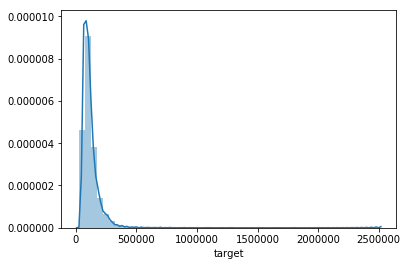

In [8]:
sns.distplot(train['target'])

- 賃料250万円はtypoの可能性があります。

In [9]:
train['target'].sort_values(ascending=False).head(10)

5093     2500000
20643    1800000
30539    1660000
1771     1450000
8706     1390000
9008     1300000
20989    1300000
15417    1300000
5775     1203500
1501     1200000
Name: target, dtype: int64

In [10]:
train[train['target']==2500000]

,id,target,Place,Access,Room,Passed,Angle,Area,Floor,Bath,Kitchen,Internet,Facility,Parking,Building,Material,Contract
5093,5094,2500000,東京都港区三田２丁目4-3,南北線\t麻布十番駅\t徒歩8分\t\t都営大江戸線\t赤羽橋駅\t徒歩9分\t\t山手線\...,2LDK+S(納戸),1年8ヶ月,西,217.29m2,9階／9階建（地下2階）,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t...,IHコンロ\t／\tコンロ3口／\tシステムキッチン\t／\tカウンターキッチン\t／\tL...,インターネット対応,エアコン付／\t床暖房\tウォークインクローゼット\tシューズボックス／\tバルコニー／\t...,"駐車場\t空有(43台)\t48,600円",【飲食店】 959m\t【飲食店】 611m\t【スーパー】 417m\t【スーパー】 65...,RC（鉄筋コンクリート）,3年間\t※この物件は\t定期借家\tです。


- 高級賃貸っぽいく、typoではないと思われます。
    - ただし、外れ値ではあるので、何らかの処置をしても良いかもしれません。

### 3-2. 所在地（Access）について

In [11]:
train['Place'].value_counts().head(10)

東京都板橋区板橋３丁目1-8         54
東京都世田谷区太子堂２丁目          53
東京都足立区新田１丁目            47
東京都中野区白鷺２丁目1-21        45
東京都中央区日本橋馬喰町２丁目4-12    44
東京都豊島区池袋３丁目            43
東京都豊島区東池袋２丁目           40
東京都墨田区緑４丁目             39
東京都豊島区南長崎５丁目           38
東京都中野区江古田３丁目14-3       38
Name: Place, dtype: int64

In [12]:
train['Place'].value_counts().tail(10)

東京都江戸川区松島２丁目8-13     1
東京都足立区西新井２丁目1-1      1
東京都大田区西糀谷１丁目11-12    1
東京都品川区大井１丁目54-3      1
東京都江東区白河３丁目8-15      1
東京都文京区本駒込１丁目25-28    1
東京都豊島区要町３丁目58-5      1
東京都足立区関原１丁目２０－４      1
東京都板橋区東山町31-11       1
東京都中野区本町６丁目12-12     1
Name: Place, dtype: int64

In [13]:
test['Place'].value_counts().head(10)

東京都世田谷区太子堂２丁目          53
東京都板橋区板橋３丁目1-8         48
東京都中野区白鷺２丁目1-21        47
東京都豊島区南長崎５丁目           47
東京都中央区勝どき６丁目           42
東京都中央区日本橋馬喰町２丁目        41
東京都江戸川区鹿骨５丁目           40
東京都板橋区高島平１丁目           40
東京都江東区海辺               39
東京都中央区日本橋馬喰町２丁目4-12    37
Name: Place, dtype: int64

- 都、区、数字・丁目、（番地）で区切れると思います。

### 3-3. アクセス（Access）について

In [14]:
train['Access'].value_counts().head(10)

都営大江戸線\t新江古田駅\t徒歩10分\t\t西武池袋線\t江古田駅\t徒歩20分\t\t西武新宿線\t沼袋駅\t徒歩15分           65
総武本線\t馬喰町駅\t徒歩4分\t\t都営浅草線\t浅草橋駅\t徒歩4分                                     61
都営三田線\t板橋区役所前駅\t徒歩5分\t\t東武東上線\t下板橋駅\t徒歩7分\t\t都営三田線\t新板橋駅\t徒歩8分            49
東西線\t木場(東京都)駅\t徒歩5分\t\t都営大江戸線\t門前仲町駅\t徒歩15分\t\t京葉線(東京－蘇我)\t越中島駅\t徒歩17分    48
西武新宿線\t鷺ノ宮駅\t徒歩8分\t\t西武新宿線\t都立家政駅\t徒歩14分\t\t西武新宿線\t下井草駅\t徒歩20分            45
総武本線\t馬喰町駅\t徒歩4分\t\t総武線・中央線（各停）\t浅草橋駅\t徒歩4分\t\t都営新宿線\t馬喰横山駅\t徒歩8分         44
都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩14分\t\t日比谷線\t築地駅\t徒歩21分                36
有楽町線\t新富町(東京都)駅\t徒歩3分\t\t日比谷線\t八丁堀(東京都)駅\t徒歩4分\t\t日比谷線\t築地駅\t徒歩5分         30
都営新宿線\t住吉(東京都)駅\t徒歩7分\t\t都営新宿線\t西大島駅\t徒歩19分\t\t都営新宿線\t菊川(東京都)駅\t徒歩20分     29
ゆりかもめ\t芝浦ふ頭駅\t徒歩2分\t\t山手線\t田町(東京都)駅\t徒歩15分\t\t都営三田線\t三田(東京都)駅\t徒歩19分      29
Name: Access, dtype: int64

In [15]:
train['Access'].value_counts().tail(10)

京浜東北線\t大森(東京都)駅\t徒歩20分\t\t京急本線\t大森町駅\t徒歩14分\t\t京急本線\t平和島駅\t徒歩12分                      1
東急東横線\t自由が丘駅\t徒歩7分\t\t東急目黒線\t奥沢駅\t徒歩2分\t\t東急東横線\t田園調布駅\t徒歩14分                         1
都営新宿線\t一之江駅\t徒歩11分\t\t都営新宿線\t瑞江駅\t徒歩18分\t\t総武線・中央線（各停）\t新小岩駅\t/バス(31分)一之江二丁目下車徒歩5分    1
南北線\t王子神谷駅\t徒歩6分\t\t京浜東北線\t東十条駅\t徒歩10分\t\t埼京線\t十条(東京都)駅\t徒歩15分                        1
京浜東北線\t赤羽駅\t徒歩19分\t\t埼京線\t北赤羽駅\t徒歩8分\t\t都営三田線\t志村坂上駅\t徒歩18分                           1
総武線・中央線（各停）\t市ケ谷駅\t徒歩5分\t\t有楽町線\t市ケ谷駅\t徒歩5分\t\t南北線\t市ケ谷駅\t徒歩5分                        1
京王線\t明大前駅\t徒歩5分\t\t京王線\t代田橋駅\t徒歩10分\t\t京王井の頭線\t永福町駅\t徒歩13分                            1
都営新宿線\t篠崎駅\t徒歩5分\t\t都営新宿線\t瑞江駅\t徒歩24分\t\t都営新宿線\t一之江駅\t徒歩43分                           1
丸ノ内線(池袋－荻窪)\t御茶ノ水駅\t徒歩7分\t\t千代田線\t湯島駅\t徒歩7分\t\t山手線\t上野駅\t徒歩14分                        1
東急多摩川線\t下丸子駅\t徒歩4分\t\t東急池上線\t千鳥町駅\t徒歩10分\t\t東急多摩川線\t鵜の木駅\t徒歩4分                        1
Name: Access, dtype: int64

In [16]:
test['Access'].value_counts().head(10)

都営大江戸線\t新江古田駅\t徒歩10分\t\t西武池袋線\t江古田駅\t徒歩20分\t\t西武新宿線\t沼袋駅\t徒歩15分           66
西武新宿線\t鷺ノ宮駅\t徒歩8分\t\t西武新宿線\t都立家政駅\t徒歩14分\t\t西武新宿線\t下井草駅\t徒歩20分            47
総武本線\t馬喰町駅\t徒歩4分\t\t都営浅草線\t浅草橋駅\t徒歩4分                                     46
都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩14分\t\t日比谷線\t築地駅\t徒歩21分                46
都営三田線\t板橋区役所前駅\t徒歩5分\t\t東武東上線\t下板橋駅\t徒歩7分\t\t都営三田線\t新板橋駅\t徒歩8分            44
東西線\t木場(東京都)駅\t徒歩5分\t\t都営大江戸線\t門前仲町駅\t徒歩15分\t\t京葉線(東京－蘇我)\t越中島駅\t徒歩17分    39
総武本線\t馬喰町駅\t徒歩4分\t\t総武線・中央線（各停）\t浅草橋駅\t徒歩4分\t\t都営新宿線\t馬喰横山駅\t徒歩8分         37
都営大江戸線\t新御徒町駅\t徒歩7分\t\t銀座線\t稲荷町(東京都)駅\t徒歩7分\t\t銀座線\t田原町(東京都)駅\t徒歩8分       29
ゆりかもめ\t芝浦ふ頭駅\t徒歩2分\t\t山手線\t田町(東京都)駅\t徒歩15分\t\t都営三田線\t三田(東京都)駅\t徒歩19分      29
西武池袋線\t東長崎駅\t徒歩1分\t\t都営大江戸線\t落合南長崎駅\t徒歩9分                                 29
Name: Access, dtype: int64

- \t, \t\tで区切れると思います。
- ただし、区切った後の個数はバラバラなので要注意です。
    - 路線・駅・駅からの移動時間が最大3セット。
    - 徒歩～分ではなく、バスの場合有り。

### 3-4. 築年数（Passed）について

In [17]:
train['Passed'].value_counts().head(10)

0年1ヶ月     983
新築        889
0年0ヶ月     704
0年2ヶ月     644
0年3ヶ月     508
0年5ヶ月     484
0年6ヶ月     378
0年4ヶ月     323
12年5ヶ月    262
11年5ヶ月    227
Name: Passed, dtype: int64

In [18]:
train['Passed'].value_counts().tail(10)

79年7ヶ月      1
57年5ヶ月      1
56年10ヶ月     1
58年11ヶ月     1
64年7ヶ月      1
52年0ヶ月      1
1019年7ヶ月    1
69年7ヶ月      1
53年10ヶ月     1
59年8ヶ月      1
Name: Passed, dtype: int64

- 年、ヶ月で区切れます。
- ただし、例外として、新築と0年0ヶ月の違いは？
- 520年5ヶ月は多分typoです（既にフォーラムにその旨あり）。

### 3-5. 方角（Angle）について

In [19]:
train['Angle'].value_counts()

南     8909
東     4995
西     4026
南東    3098
南西    3080
北     1966
北西    1326
北東    1321
Name: Angle, dtype: int64

- 処置の必要はなさそうです。
- 日当たりが良い南方面が多く、日当たりが悪い北方面が少ないという知識に合います。

### 3-6. 面積（Area）について

In [20]:
train['Area'].value_counts().head(10)

20m2       226
40m2       209
18m2       188
21m2       169
30m2       164
25m2       143
16m2       121
22m2       117
15m2       111
19.87m2    110
Name: Area, dtype: int64

In [21]:
train['Area'].value_counts().tail(10)

63.83m2    1
35.88m2    1
17.44m2    1
59.14m2    1
72.67m2    1
6.45m2     1
12.26m2    1
69.03m2    1
19.23m2    1
51.96m2    1
Name: Area, dtype: int64

- :-2で取り出せそうです。

### 3-7. バス・トイレ（Bath）について

In [22]:
train['Bath'].value_counts().head(10)

専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t／\t温水洗浄便座／\t洗面台独立／\t脱衣所    4606
専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座／\t洗面台独立／\t脱衣所           2936
専用バス／\t専用トイレ／\tシャワー                                                      2133
専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー                                            1495
専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t／\t温水洗浄便座／\t洗面台独立           873
シャワー                                                                      849
専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t洗面台独立／\t脱衣所                               802
バス・トイレ別／\tシャワー／\t追焚機能／\t浴室乾燥機\t／\t温水洗浄便座／\t洗面台独立                          795
専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座／\t洗面台独立                  708
バス・トイレ別／\tシャワー                                                            656
Name: Bath, dtype: int64

- \t,／\tで区切れそうです。
- ただし、出てくる属性数はバラバラなので要注意です。

### 3-8. 周辺環境（Building）について

In [23]:
train['Building'].value_counts().head(10)

【スーパー】 264m\t【スーパー】 848m\t【スーパー】 969m\t【コンビニ】 191m\t【コンビニ】 378m                  48
【スーパー】 227m\t【スーパー】 442m\t【スーパー】 422m\t【コンビニ】 260m\t【コンビニ】 320m                  47
【スーパー】 231m\t【スーパー】 309m\t【スーパー】 593m\t【コンビニ】 103m\t【コンビニ】 389m                  44
【スーパー】 292m\t【コンビニ】 341m                                                         40
【スーパー】 501m\t【スーパー】 924m\t【スーパー】 713m\t【コンビニ】 108m\t【コンビニ】 275m\t【コンビニ】 469m     28
【スーパー】 275m\t【スーパー】 478m\t【スーパー】 1118m\t【コンビニ】 140m\t【コンビニ】 153m\t【コンビニ】 375m    25
【スーパー】 702m\t【スーパー】 789m\t【スーパー】 959m\t【コンビニ】 54m\t【コンビニ】 195m                   24
【スーパー】 422m\t【スーパー】 442m\t【スーパー】 686m\t【コンビニ】 398m\t【病院】 612m                    23
【コンビニ】 100m\t【コンビニ】 300m\t【コンビニ】 410m\t【スーパー】 10m\t【幼稚園・保育園】 1800m\t【公園】 330m    23
【スーパー】 346m\t【スーパー】 552m\t【コンビニ】 238m\t【コンビニ】 613m                               22
Name: Building, dtype: int64

- 建物と距離をどう扱うかが問題になりそうです。
- 住所が似たようなものは、周辺環境も似たようなものになるかと思います。

- 一部変数は似たようなことになるので省略しました。

## 4. Feature Engineering

- ここでは、前処理不要な簡単なもののみ作ります。

In [24]:
def makeCountFull(train, test, categorical_features=None, report=True):
    add_cols = categorical_features
    if report:
        print('add_cols: ', add_cols)
    for add_col in add_cols:
        train[add_col + '_countall'] = train[add_col].map(pd.concat([train[add_col], test[add_col]], ignore_index=True).value_counts(dropna=False))
        test[add_col + '_countall'] = test[add_col].map(pd.concat([train[add_col], test[add_col]], ignore_index=True).value_counts(dropna=False))
    return train, test

In [25]:
cat_features = ['Place', 'Access', 'Room', 'Passed', 'Angle', 'Area', 'Floor', 'Bath', 'Kitchen', 'Internet', 'Facility', 'Parking', 'Building', 'Material', 'Contract']
train, test = makeCountFull(train, test, cat_features)

add_cols:  ['Place', 'Access', 'Room', 'Passed', 'Angle', 'Area', 'Floor', 'Bath', 'Kitchen', 'Internet', 'Facility', 'Parking', 'Building', 'Material', 'Contract']


- trainとtestを同時にCountしています。
    - 別個にCountしてみると面白いかもしれません。

In [26]:
cat_cols = ['Place', 'Access', 'Room', 'Passed', 'Angle', 'Area', 'Floor', 'Bath',
            'Kitchen', 'Internet', 'Facility', 'Parking', 'Building', 'Material', 'Contract']
for col in cat_cols:
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)
    le = LabelEncoder()
    le.fit(list(train[col])+list(test[col]))
    train[col] = le.transform(train[col])
    test[col]    = le.transform(test[col])    
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

## 5. Model

- モデルを作成します。

### 5-1. Model training

In [27]:
X = train.drop(['id', 'target'], axis=1)
y = train['target']
X_test = test.drop(['id'], axis=1)

- 特に理由なくLightGBMを使っています。
- パラメータはチューニングしていません。

In [28]:
y_pred = np.zeros(X_test.shape[0], dtype='float32')
train_pred = np.zeros(X.shape[0], dtype='float32')

cv_score = 0
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)
train_data = lgb.Dataset(X_train, y_train)
valid_data = lgb.Dataset(X_valid, y_valid)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': -1,
    'num_leaves': 255,
    'max_bin': 255,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'nthread': -1,
    'bagging_freq': 1,
    'verbose': -1,
    'seed': 1,
}
model = lgb.train(params, train_data, valid_sets=[train_data, valid_data],
                  num_boost_round=5000, early_stopping_rounds=200,
                  verbose_eval=200)

y_val_pred = model.predict(X_valid)
val_score = np.sqrt(mean_squared_error(y_valid, y_val_pred))
print('RMSE:', val_score)

y_pred += model.predict(X_test, num_iteration=model.best_iteration)

Training until validation scores don't improve for 200 rounds.
[200]	training's rmse: 33690.1	valid_1's rmse: 43046.7
[400]	training's rmse: 23656.7	valid_1's rmse: 38878.2
[600]	training's rmse: 18403.8	valid_1's rmse: 37603.5
[800]	training's rmse: 15028.1	valid_1's rmse: 36927.5
[1000]	training's rmse: 12524.6	valid_1's rmse: 36518.9
[1200]	training's rmse: 10561.7	valid_1's rmse: 36265.6
[1400]	training's rmse: 8990.44	valid_1's rmse: 36035.4
[1600]	training's rmse: 7741.07	valid_1's rmse: 35899.1
[1800]	training's rmse: 6707.87	valid_1's rmse: 35755.5
[2000]	training's rmse: 5846.19	valid_1's rmse: 35648.1
[2200]	training's rmse: 5132.23	valid_1's rmse: 35554.2
[2400]	training's rmse: 4513.1	valid_1's rmse: 35464.6
[2600]	training's rmse: 3995.28	valid_1's rmse: 35403.1
[2800]	training's rmse: 3536.49	valid_1's rmse: 35337.1
[3000]	training's rmse: 3159.48	valid_1's rmse: 35302.6
[3200]	training's rmse: 2819.36	valid_1's rmse: 35260.9
[3400]	training's rmse: 2535.11	valid_1's rmse

In [29]:
cv_score += val_score
print(cv_score)

35076.52504457393


- （Validationを使ってtestの評価云々は非常に敏感な話題なので、一概に言えるものではないと思いますが）大体、36000+あたりのスコアになりそうです。
    - スコアボードでは40000程度のスコアになりました。
        - バリデーションはきちんと行いましょう。

### 5-2. Feature importance

In [30]:
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns
feature_importances['importance'] = model.feature_importance()
feature_importances = feature_importances.sort_values(by='importance', ascending=False)
feature_importances

,feature,importance
20,Area_countall,145543
25,Facility_countall,95022
21,Floor_countall,92243
18,Passed_countall,84047
15,Place_countall,79280
26,Parking_countall,73624
23,Kitchen_countall,62007
22,Bath_countall,61008
9,Internet,57389
17,Room_countall,56645


- 今回の簡単なモデルでは、CountEncodingがかなり効いています。
- そのままLabelEncodingしただけのInternetとPassedが効いているので、前処理はそこら辺から始めると良いかもしれません。

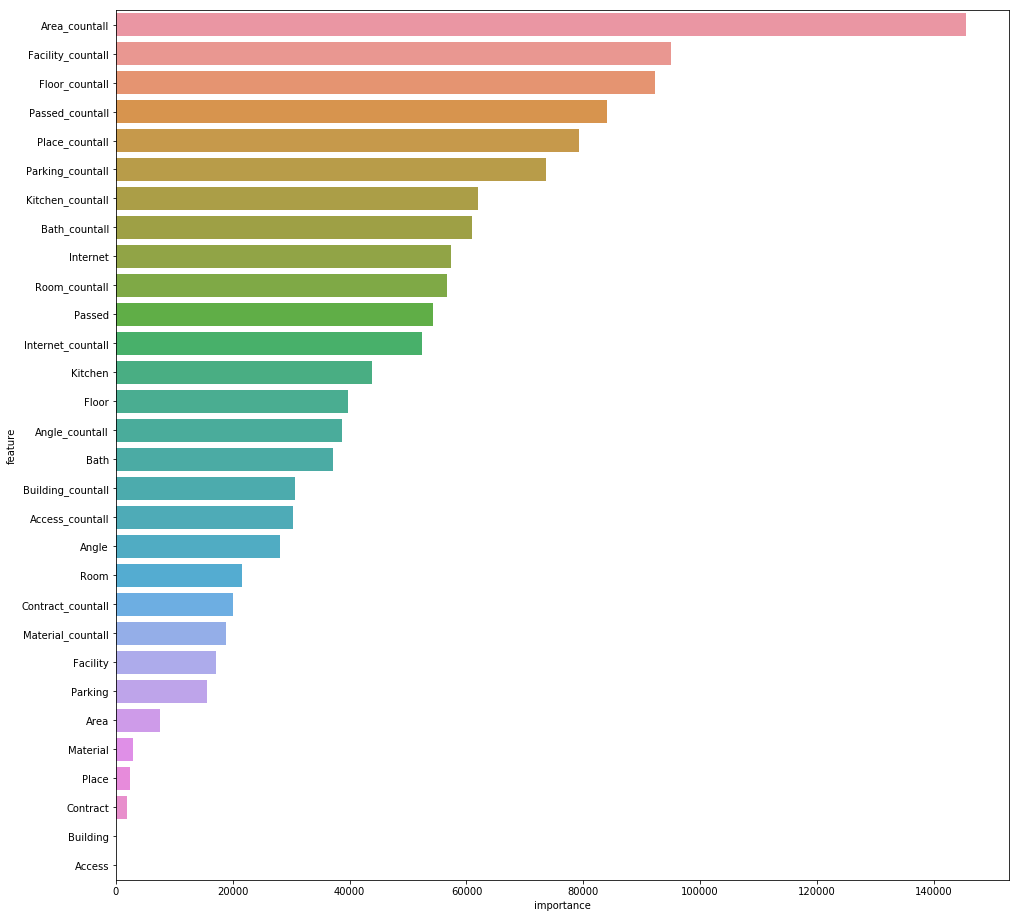

In [31]:
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.head(50), x='importance', y='feature')

### 5-3. Model prediction

In [32]:
submit['target'] = y_pred
submit.head(10)

,id,target
0,31471,180644.656250
1,31472,125228.585938
2,31473,74702.906250
3,31474,49380.605469
4,31475,117579.796875
5,31476,51928.968750
6,31477,81321.437500
7,31478,82284.367188
8,31479,82127.078125
9,31480,134087.359375


In [33]:
submit['target'].describe()

count    3.126200e+04
mean     1.180088e+05
std      6.223985e+04
min      1.278439e+04
25%      7.858586e+04
50%      1.030596e+05
75%      1.366316e+05
max      1.221313e+06
Name: target, dtype: float64

- 平均は大体118000円、形式も問題なさそうです。
    - １日３サブまでなので、indexやheaderやLeakageに気を付けましょう。
    - （既に2回やりました）

In [34]:
submit.to_csv('submit_kernel_01.csv', header=False, index=False)

## 6. Next step

- 次にやることとして、以下のようなことが考えられます。
    - 前処理
        - ライブラリとしては、re, mojimoji等が役に立つと思います。
        - 関数としては、re.split()が役に立つかもしれません。
        - df['hogehgoe'] = df['hoge'].apply(lambda x: func(x))のようなものが役に立つかもしれません。
    - EDA
        - （良く分からないです。必要に応じて適宜やると良いと思います。）
    - Feature Engineering
        - 前処理終わると疎な属性が大量に出てくるので、木を使うならば何かしないといけない気がします。
    - Validation
        - KFoldか、適当な属性毎のGroupKFoldが良い気がしますが、議論の余地があると思います。
    - Model
        - LightGBMだけでなく、CatboostやNNも試す価値は十分にあると思います。
    - Teaming
        - 昨年のフォーラムを見るに余りKernelが無いようなので、知見を得る意味でもTeamingは良いかと思います。
        - IEEE(kaggleのテーブルコンペ)があと3日で終わるので、そこら辺でスコアボードが一変するかと思います。

## 追記. TrainとTestの違い

- やっていて、微妙にTrainとTestの分布が違うような気がしたので検証しました。

In [35]:
train['target'] = 1
test['target'] = 0
df = pd.concat([train, test])
X = df.drop(['id', 'target'], axis=1)
y = df['target']

In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)
train_data = lgb.Dataset(X_train, y_train)
valid_data = lgb.Dataset(X_valid, y_valid)
params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.01,
    'max_depth': -1,
    'num_leaves': 255,
    'max_bin': 255,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'nthread': -1,
    'bagging_freq': 1,
    'verbose': -1,
    'seed': 1,
}
model = lgb.train(params, train_data, valid_sets=[train_data, valid_data],
                  num_boost_round=5000, early_stopping_rounds=200,
                  verbose_eval=200)

y_val_pred = model.predict(X_valid)
val_score =roc_auc_score(y_valid, y_val_pred)
print('AUC:', val_score)

Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.954007	valid_1's auc: 0.504055
Early stopping, best iteration is:
[7]	training's auc: 0.733928	valid_1's auc: 0.505508
AUC: 0.5055084488161163


- 気のせいでした。